<a href="https://colab.research.google.com/github/justinwickelgren/data-science-class/blob/main/JustWickU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Australian Port Emisssions

This project uses a University of Florida data set of emissions, fuel consumption, and berth visits (number of ships) for several Australian ports. It will attempt to model the relationship between the number of berth visits at each port and CO<sub>2</sub> equivalent emissions. This is interesting to me because I am curious whether ports with more ships are likely to have larger ships or not. If they have larger ships, I would expect the best model to have a positive second derivative; if there is no relation between number of ships and size of ships, it will have a zero second derivative; and if the correlation between number of ships and ship size is negative, it will have a negative second derivative.

In [32]:
url = "https://users.stat.ufl.edu/~winner/data/ship_emissions2.csv"
port_emissions = pd.read_csv(url)
port_emissions

,Port,Fuel,NO_x,SO_2,PM_10,PM_2.5,VOC,CO,PAH,CO_2e,BerthVisits
0,Melbourne,76383,4375,3940,478,440,99,277,1.45,247618,3065
1,Dampier,62287,3131,2869,343,315,87,262,1.09,201753,3821
2,Brisbane,60752,3140,3045,362,333,75,192,1.11,197155,2271
3,Hay Point,40352,1896,2113,245,225,60,164,0.74,130725,841
4,Fremantle,38135,1597,1798,204,187,46,127,0.64,123790,1633
5,Port Hedland,24215,1246,1088,131,121,36,103,0.43,78397,1357
6,Botany,19535,698,1022,112,103,23,62,0.34,63454,1345
7,Gladstone,15127,801,709,85,78,21,58,0.27,49021,1243
8,Port Jackson,12831,585,403,47,44,13,50,0.19,41465,278
9,Newcastle,12499,588,555,65,60,17,52,0.21,40492,1703


Text(0, 0.5, 'CO_2e')

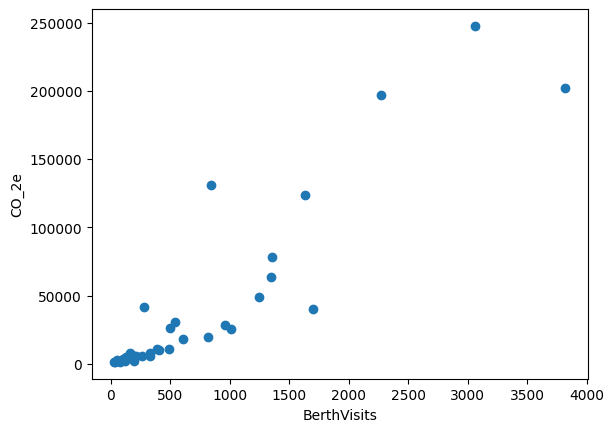

In [33]:
x = "BerthVisits"
y = "CO_2e"
plt.scatter(port_emissions[x], port_emissions[y])
plt.xlabel(x)
plt.ylabel(y)

Because there is not very much data at the top right, it is hard to say what the best model to try first will be. I will try a normal likelihood with a linear model first.

In [34]:
with pm.Model() as model:
    α = pm.Normal("α", mu=0, sigma=3)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 1)

    μ = pm.Deterministic("μ", α + β * port_emissions[x]) # linear part of the model

    y = pm.Normal("y_pred", # normal variation away from the line
                  mu=μ,
                  sigma=σ,
                  observed=port_emissions[y])
    data = pm.sample()

Output()

Output()

Text(0, 0.5, 'y_pred')

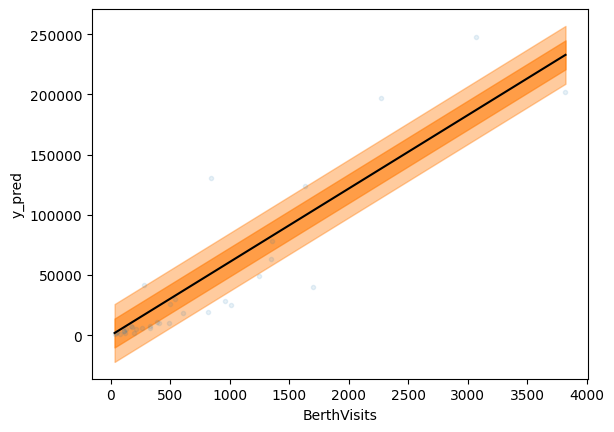

In [35]:
# graph line
_, ax = plt.subplots()

ax.plot(port_emissions["BerthVisits"], port_emissions["CO_2e"], "C0.", alpha=0.1)

posterior = az.extract(data)

μ_m = np.sort(posterior["μ"].mean("sample").values) # sort to make the line connect points in the correct order (same with sorts below)
σ_m = posterior["σ"].mean("sample").values

ax.plot(np.sort(port_emissions[x]), μ_m, c="k")
ax.fill_between(np.sort(port_emissions[x]), μ_m + 30 * σ_m, μ_m - 30 * σ_m, alpha=0.6, color="C1")
ax.fill_between(np.sort(port_emissions[x]), μ_m + 60 * σ_m, μ_m - 60 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel(x)
ax.set_ylabel(y)

Output()

<Axes: xlabel='y_pred'>

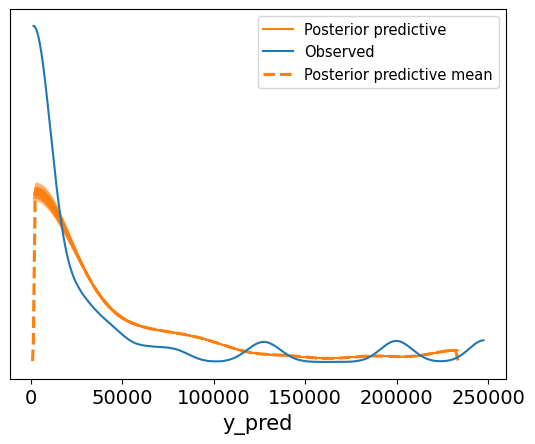

In [36]:
pm.sample_posterior_predictive(data, model=model, extend_inferencedata=True) # sample posterior predictive
az.plot_ppc(data, num_pp_samples=200, colors=["C1", "C0", "C1"]) # graph posterior predictive check

This model is fine, but I don't think it captures the convex shape of the data in the bottom left, which is where most of the data is. I think normal variation away from the line is working well enough. The posterior predictive check also shows a relatively close, but not perfect, match. I will try squaring the number of berth visits to create a quadratic shaped function that should model the bottom left more closely.

In [37]:
with pm.Model() as model:
    α = pm.Normal("α", mu=0, sigma=3)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 1)

    μ = pm.Deterministic("μ", α + β * pm.math.sqr(port_emissions["BerthVisits"])) # linear model with squared berth visits values

    y = pm.Normal("y_pred",
                  mu=μ,
                  sigma=σ,
                  observed=port_emissions["CO_2e"]) # normal likelihood
    data = pm.sample()

Output()

Output()

Text(0, 0.5, 'y_pred')

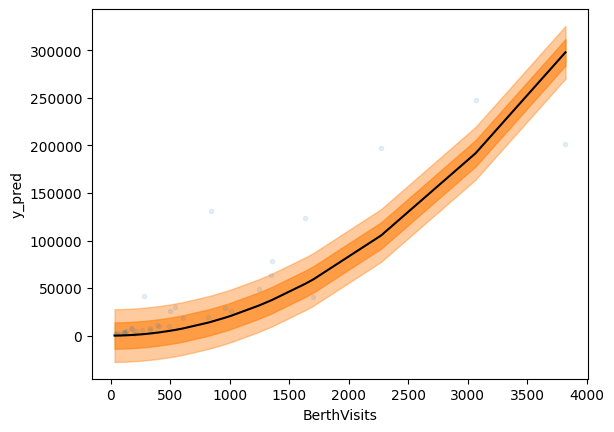

In [38]:
# graph line
_, ax = plt.subplots()

ax.plot(port_emissions["BerthVisits"], port_emissions["CO_2e"], "C0.", alpha=0.1)

posterior = az.extract(data)

μ_m = np.sort(posterior["μ"].mean("sample").values) # sort to make the line connect points in the correct order (same with sorts below)
σ_m = posterior["σ"].mean("sample").values

ax.plot(np.sort(port_emissions[x]), μ_m, c="k")
ax.fill_between(np.sort(port_emissions[x]), μ_m + 30 * σ_m, μ_m - 30 * σ_m, alpha=0.6, color="C1")
ax.fill_between(np.sort(port_emissions[x]), μ_m + 60 * σ_m, μ_m - 60 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel(x)
ax.set_ylabel(y)

Output()

<Axes: xlabel='y_pred'>

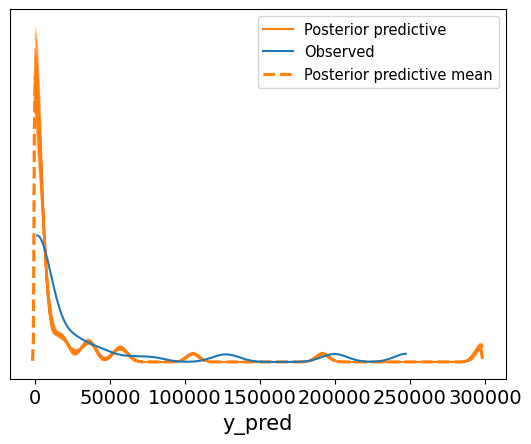

In [39]:
pm.sample_posterior_predictive(data, model=model, extend_inferencedata=True) # sample posterior predictive
az.plot_ppc(data, num_pp_samples=200, colors=["C1", "C0", "C1"]) # graph posterior predictive check

I think this posterior predictive check matches about as well as the previous model. The other graph, however, models the data more accurately. Neither captures the top right. outliers super well, but this one is better with the bulk of the data in the bottom left. Additionally, I think the quadratic shape more accurately models the underlying process. Because this dataset is limited to Australia, it lacks a lot of data on large ports, but I would expect them to have more large ships. This is because larger ships are probably too large for many smaller ports and they require more demand for shipping that only larger ports would have.